In [14]:
# Bloc 3.0 – Infrastructure commune d'estimation de d :
#             chargement de la série et des définitions de fenêtres

import pandas as pd
from pathlib import Path

# 3.0.1 – Vérification de PHASE2_ROOT
try:
    PHASE2_ROOT
except NameError:
    raise RuntimeError(
        "PHASE2_ROOT n'est pas défini. "
        "Assurez-vous d'avoir exécuté les blocs 0.x avant ce bloc."
    )

# 3.0.2 – Rechargement de la série de référence S0 depuis Sunspots_clean.csv (sécurité)
DATA_PHASE2_CLEAN_DIR = PHASE2_ROOT / "data_phase2" / "sunspots_clean"
SUNSPOTS_CLEAN_CSV_PATH = DATA_PHASE2_CLEAN_DIR / "Sunspots_clean.csv"

if not SUNSPOTS_CLEAN_CSV_PATH.exists():
    raise FileNotFoundError(
        f"Sunspots_clean.csv introuvable à l'emplacement : {SUNSPOTS_CLEAN_CSV_PATH}.\n"
        "Assurez-vous que le Bloc 1.4 a bien été exécuté."
    )

df_sunspots_clean = pd.read_csv(SUNSPOTS_CLEAN_CSV_PATH, parse_dates=["Date"])
df_ts = df_sunspots_clean.sort_values("Date").set_index("Date")

print("Série S0 (brute nettoyée) rechargée depuis Sunspots_clean.csv :")
print(f"  - shape = {df_ts.shape}")
print(f"  - index min/max = {df_ts.index.min().date()} -> {df_ts.index.max().date()}")

# 3.0.3 – Chargement des définitions de fenêtres
WINDOW_DEFS_PATH = PHASE2_ROOT / "data_phase2" / "windows" / "window_definitions.csv"

if not WINDOW_DEFS_PATH.exists():
    raise FileNotFoundError(
        f"window_definitions.csv introuvable à l'emplacement : {WINDOW_DEFS_PATH}.\n"
        "Assurez-vous d'avoir exécuté le Bloc 2.4."
    )

df_windows = pd.read_csv(
    WINDOW_DEFS_PATH,
    parse_dates=["start_date", "end_date"],
)

n_windows_total = len(df_windows)
unique_W = sorted(df_windows["window_size_months"].unique().tolist())
unique_G = sorted(df_windows["stride_months"].unique().tolist())

print("\nDéfinitions de fenêtres chargées :")
print(f"  - Nombre total de fenêtres : {n_windows_total}")
print(f"  - Tailles de fenêtre (mois) : {unique_W}")
print(f"  - Pas de glissement (mois)  : {unique_G}")

print("\nRésumé par combinaison (W, G) :")
summary = (
    df_windows
    .groupby(["window_size_months", "stride_months"])
    .size()
    .reset_index(name="n_windows")
    .sort_values(["window_size_months", "stride_months"])
)
display(summary)

# 3.0.4 – Vérifications simples de cohérence
max_end_index = int(df_windows["end_index"].max())
if max_end_index >= len(df_ts):
    raise RuntimeError(
        f"Incohérence potentielle : end_index max = {max_end_index}, "
        f"len(df_ts) = {len(df_ts)}."
    )

print(f"\nVérification : end_index max = {max_end_index}, len(df_ts) = {len(df_ts)} -> OK.")

# 3.0.5 – Logging
log_message(
    "INFO",
    (
        f"Infra Bloc 3.0 : série S0 rechargée (shape={df_ts.shape}), "
        f"fenêtres chargées (total={n_windows_total}, W={unique_W}, G={unique_G})."
    ),
    block="BLOC_3.0",
)
log_metric(
    "bloc3_infra_loaded",
    True,
    extra={
        "n_windows_total": int(n_windows_total),
        "window_sizes": unique_W,
        "strides": unique_G,
        "series_length": int(len(df_ts)),
    },
)

Série S0 (brute nettoyée) rechargée depuis Sunspots_clean.csv :
  - shape = (3265, 1)
  - index min/max = 1749-01-31 -> 2021-01-31

Définitions de fenêtres chargées :
  - Nombre total de fenêtres : 11682
  - Tailles de fenêtre (mois) : [60, 132, 264]
  - Pas de glissement (mois)  : [1, 6, 12]

Résumé par combinaison (W, G) :


,window_size_months,stride_months,n_windows
0,60,1,3206
1,60,6,535
2,60,12,268
3,132,1,3134
4,132,6,523
5,132,12,262
6,264,1,3002
7,264,6,501
8,264,12,251



Vérification : end_index max = 3264, len(df_ts) = 3265 -> OK.
[STEP=12][INFO][BLOC_3.0] Infra Bloc 3.0 : série S0 rechargée (shape=(3265, 1)), fenêtres chargées (total=11682, W=[60, 132, 264], G=[1, 6, 12]).
[METRIC][bloc3_infra_loaded] = True (step=12)


### Bloc 3.1 – Sous‑échantillon de fenêtres pour la calibration des méthodes de `d`

Nous disposons de 11 682 fenêtres (W60/W132/W264 × G1/G6/G12).  
Pour explorer le comportement des méthodes d’estimation de `d` (M1, M2, M3) sans perdre
le contrôle, nous commençons par un **sous‑échantillon de calibration**.

Stratégie :

- Pour chaque combinaison `(window_size_months = W, stride_months = G)` :
  - sélectionner un nombre fixe de fenêtres, par exemple **N = 40** ;
  - si le groupe contient moins de 40 fenêtres, prendre **toutes** les fenêtres ;
  - les fenêtres choisies sont **réparties uniformément** sur la période (pas de tirage aléatoire),
    en prenant des indices régulièrement espacés dans le groupe.
- Cette sélection est **déterministe** (aucun hasard), donc reproductible.

Le sous‑échantillon sera sauvegardé dans :

- `data_phase2/windows/window_calibration_subset.csv`

avec, pour chaque fenêtre de calibration :

- `window_id` (référence à [window_definitions.csv](cci:7://file:///c:/Users/zackd/OneDrive/Desktop/Phase2_Tlog_v0.5/SunspotPhase2Tlog/data_phase2/windows/window_definitions.csv:0:0-0:0))
- `window_size_months`, `stride_months`
- `start_index`, `end_index`
- `start_date`, `end_date`
- `n_points`

Ce sous‑ensemble sera utilisé pour :

- tester les méthodes M1, M2, M3 ;
- choisir et justifier les hyperparamètres (plage de `k`, paramètres spectre/PCA, etc.) ;
- identifier les comportements instables avant d’appliquer les méthodes à toutes les fenêtres.

In [15]:
# Bloc 3.1 – Construction et sauvegarde du sous-échantillon de calibration

import numpy as np
import pandas as pd

# 3.1.1 – Vérification df_windows
try:
    df_windows
except NameError:
    raise RuntimeError(
        "df_windows n'est pas défini. "
        "Assurez-vous d'avoir exécuté le Bloc 3.0 avant ce bloc."
    )

# Nombre cible de fenêtres par combinaison (W, G)
N_CALIB_PER_GROUP = 40

groups = df_windows.groupby(["window_size_months", "stride_months"], sort=True)

calib_records = []
for (W, G), group in groups:
    n_group = len(group)
    n_select = min(N_CALIB_PER_GROUP, n_group)

    # indices régulièrement espacés dans le groupe (déterministe, sans hasard)
    if n_select == 1:
        idx_positions = [0]
    else:
        idx_positions = np.linspace(
            0, n_group - 1, num=n_select, endpoint=True, dtype=int
        )

    subset = group.iloc[idx_positions].copy()
    calib_records.append(subset)

    print(
        f"(W={W}, G={G}) : n_total={n_group}, n_calib={n_select}, "
        f"indices sélectionnés (positions dans le groupe) : {list(idx_positions)}"
    )

df_windows_calib = pd.concat(calib_records, ignore_index=True)

print("\nRésumé du sous-échantillon de calibration :")
print(f"  - Nombre total de fenêtres de calibration : {len(df_windows_calib)}")
print("  - Aperçu des 5 premières lignes :")
display(df_windows_calib.head())

# 3.1.2 – Sauvegarde dans data_phase2/windows/window_calibration_subset.csv
WINDOWS_DIR = PHASE2_ROOT / "data_phase2" / "windows"
WINDOWS_DIR.mkdir(parents=True, exist_ok=True)

WINDOW_CALIB_PATH = WINDOWS_DIR / "window_calibration_subset.csv"
df_windows_calib.to_csv(WINDOW_CALIB_PATH, index=False)

print("\nSous-échantillon de calibration sauvegardé à l'emplacement :")
print(f"  - {WINDOW_CALIB_PATH}")

# 3.1.3 – Logging
log_message(
    "INFO",
    (
        f"Sous-échantillon de calibration construit : total={len(df_windows_calib)}, "
        f"N_CALIB_PER_GROUP={N_CALIB_PER_GROUP}, fichier={WINDOW_CALIB_PATH.name}"
    ),
    block="BLOC_3.1",
)
log_metric(
    "windows_calibration_subset_count",
    int(len(df_windows_calib)),
    extra={
        "N_CALIB_PER_GROUP": int(N_CALIB_PER_GROUP),
        "path": str(WINDOW_CALIB_PATH),
    },
)

(W=60, G=1) : n_total=3206, n_calib=40, indices sélectionnés (positions dans le groupe) : [np.int64(0), np.int64(82), np.int64(164), np.int64(246), np.int64(328), np.int64(410), np.int64(493), np.int64(575), np.int64(657), np.int64(739), np.int64(821), np.int64(903), np.int64(986), np.int64(1068), np.int64(1150), np.int64(1232), np.int64(1314), np.int64(1397), np.int64(1479), np.int64(1561), np.int64(1643), np.int64(1725), np.int64(1807), np.int64(1890), np.int64(1972), np.int64(2054), np.int64(2136), np.int64(2218), np.int64(2301), np.int64(2383), np.int64(2465), np.int64(2547), np.int64(2629), np.int64(2711), np.int64(2794), np.int64(2876), np.int64(2958), np.int64(3040), np.int64(3122), np.int64(3205)]
(W=60, G=6) : n_total=535, n_calib=40, indices sélectionnés (positions dans le groupe) : [np.int64(0), np.int64(13), np.int64(27), np.int64(41), np.int64(54), np.int64(68), np.int64(82), np.int64(95), np.int64(109), np.int64(123), np.int64(136), np.int64(150), np.int64(164), np.int64(

,window_id,window_size_months,stride_months,start_index,end_index,start_date,end_date,n_points
0,0,60,1,0,59,1749-01-31,1753-12-31,60
1,82,60,1,82,141,1755-11-30,1760-10-31,60
2,164,60,1,164,223,1762-09-30,1767-08-31,60
3,246,60,1,246,305,1769-07-31,1774-06-30,60
4,328,60,1,328,387,1776-05-31,1781-04-30,60



Sous-échantillon de calibration sauvegardé à l'emplacement :
  - C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\windows\window_calibration_subset.csv
[STEP=13][INFO][BLOC_3.1] Sous-échantillon de calibration construit : total=360, N_CALIB_PER_GROUP=40, fichier=window_calibration_subset.csv
[METRIC][windows_calibration_subset_count] = 360 (step=13)


### Bloc 3.2 – Construction des matrices de fenêtres S0 pour M1 (Levina–Bickel)

Pour appliquer M1 (Levina–Bickel) de façon contrôlée, nous devons représenter les fenêtres
comme des vecteurs dans un espace de dimension `W` :

- chaque fenêtre = un vecteur de longueur `W` (les valeurs mensuelles consécutives) ;
- pour chaque couple `(window_size_months = W, stride_months = G)` du **sous-échantillon
  de calibration**, nous aurons donc une matrice :

  - lignes : fenêtres de calibration (≈ 40 par (W, G)) ;
  - colonnes : positions temporelles dans la fenêtre (0, 1, ..., W‑1).

Dans ce bloc, nous allons :

- recharger le sous-échantillon de calibration depuis  
  `data_phase2/windows/window_calibration_subset.csv` ;
- pour chaque combinaison `(W, G)` :
  - extraire, à partir de la série S0 (df_ts), les segments correspondants (indices start/end) ;
  - construire une matrice `n_calib × W` ;
  - sauvegarder cette matrice dans un fichier CSV dédié, par exemple :

    - `data_phase2/windows/calibration_matrices/S0_W60_G1_calib.csv`
    - `data_phase2/windows/calibration_matrices/S0_W132_G6_calib.csv`
    - etc.

Ces fichiers serviront ensuite d’entrée à M1 pour explorer l’estimation de `d`
sur des fenêtres de taille W, avec des hyperparamètres bien contrôlés.

In [16]:
# Bloc 3.2 – Construction et sauvegarde des matrices de fenêtres S0 (calibration)

import numpy as np
import pandas as pd
from pathlib import Path

# 3.2.1 – Vérification des objets nécessaires
try:
    df_ts
except NameError:
    raise RuntimeError(
        "df_ts n'est pas défini. Assurez-vous d'avoir exécuté le Bloc 3.0 avant ce bloc."
    )

value_col = "Monthly Mean Total Sunspot Number"

WINDOWS_DIR = PHASE2_ROOT / "data_phase2" / "windows"
WINDOW_CALIB_PATH = WINDOWS_DIR / "window_calibration_subset.csv"

if not WINDOW_CALIB_PATH.exists():
    raise FileNotFoundError(
        f"window_calibration_subset.csv introuvable à l'emplacement : {WINDOW_CALIB_PATH}.\n"
        "Assurez-vous d'avoir exécuté le Bloc 3.1."
    )

# 3.2.2 – Chargement du sous-échantillon de calibration
df_windows_calib = pd.read_csv(
    WINDOW_CALIB_PATH,
    parse_dates=["start_date", "end_date"],
)

print(f"Sous-échantillon de calibration chargé : {len(df_windows_calib)} fenêtres.")
print("Aperçu des 5 premières lignes :")
display(df_windows_calib.head())

# 3.2.3 – Dossier de sortie pour les matrices
CALIB_MATRICES_DIR = WINDOWS_DIR / "calibration_matrices"
CALIB_MATRICES_DIR.mkdir(parents=True, exist_ok=True)

# 3.2.4 – Construction des matrices pour chaque combinaison (W, G)
groups = df_windows_calib.groupby(["window_size_months", "stride_months"], sort=True)

matrix_files = []

for (W, G), group in groups:
    group = group.sort_values("start_index").reset_index(drop=True)
    window_ids = group["window_id"].astype(int).to_numpy()
    n_windows = len(group)

    # Extraction des valeurs pour chaque fenêtre
    rows = []
    for _, row in group.iterrows():
        start_idx = int(row["start_index"])
        end_idx = int(row["end_index"])

        # +1 car end_index est inclusif
        values = df_ts.iloc[start_idx : end_idx + 1][value_col].to_numpy()

        if len(values) != W:
            raise RuntimeError(
                f"Longueur inattendue pour la fenêtre window_id={row['window_id']} "
                f"(attendu W={W}, obtenu {len(values)})."
            )

        rows.append(values)

    X = np.vstack(rows)  # shape (n_windows, W)

    # Construction du DataFrame : colonne window_id + colonnes t_0 ... t_{W-1}
    col_names = ["window_id"] + [f"t_{i}" for i in range(W)]
    data = np.column_stack([window_ids, X])
    df_matrix = pd.DataFrame(data, columns=col_names)

    out_name = f"S0_W{W}_G{G}_calib.csv"
    out_path = CALIB_MATRICES_DIR / out_name
    df_matrix.to_csv(out_path, index=False)

    print(
        f"\nMatrice de calibration construite pour (W={W}, G={G}) : "
        f"{df_matrix.shape[0]} fenêtres x {W} colonnes de valeurs."
    )
    print(f"  - Fichier sauvegardé : {out_path}")

    matrix_files.append(str(out_path))

# 3.2.5 – Logging
log_message(
    "INFO",
    (
        f"Matrices de calibration S0 construites pour {len(groups)} combinaisons (W,G). "
        f"Fichiers créés dans {CALIB_MATRICES_DIR}."
    ),
    block="BLOC_3.2",
)
log_metric(
    "calibration_matrices_S0_count",
    int(len(matrix_files)),
    extra={
        "matrix_files": matrix_files,
    },
)

Sous-échantillon de calibration chargé : 360 fenêtres.
Aperçu des 5 premières lignes :


,window_id,window_size_months,stride_months,start_index,end_index,start_date,end_date,n_points
0,0,60,1,0,59,1749-01-31,1753-12-31,60
1,82,60,1,82,141,1755-11-30,1760-10-31,60
2,164,60,1,164,223,1762-09-30,1767-08-31,60
3,246,60,1,246,305,1769-07-31,1774-06-30,60
4,328,60,1,328,387,1776-05-31,1781-04-30,60



Matrice de calibration construite pour (W=60, G=1) : 40 fenêtres x 60 colonnes de valeurs.
  - Fichier sauvegardé : C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\windows\calibration_matrices\S0_W60_G1_calib.csv

Matrice de calibration construite pour (W=60, G=6) : 40 fenêtres x 60 colonnes de valeurs.
  - Fichier sauvegardé : C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\windows\calibration_matrices\S0_W60_G6_calib.csv

Matrice de calibration construite pour (W=60, G=12) : 40 fenêtres x 60 colonnes de valeurs.
  - Fichier sauvegardé : C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\windows\calibration_matrices\S0_W60_G12_calib.csv

Matrice de calibration construite pour (W=132, G=1) : 40 fenêtres x 132 colonnes de valeurs.
  - Fichier sauvegardé : C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\windows\calibration_matrices\S0_W132_G1_calib.csv

Matrice de cal

### Bloc 3.3 – Méthode M1 : Estimation de `d` par Levina–Bickel (sur S0, calibration)

Nous appliquons maintenant la méthode de **dimension intrinsèque de Levina–Bickel** sur
les matrices de fenêtres S0 construites au Bloc 3.2.

#### 3.3.1 Idée générale

Pour une matrice de fenêtres donnée (par exemple S0_W132_G6_calib) :

- chaque fenêtre est un **point** dans \\( \mathbb{R}^W \\) (W = taille de fenêtre en mois) ;
- on considère les **distances k-plus proches voisins** entre ces points (k‑NN) ;
- la dimension intrinsèque `d` est estimée à partir de la façon dont les distances
  croissent avec `k`.

Formule classique (version Levina–Bickel) :

1. Pour chaque point \\( i \\) on trie les distances à ses voisins :  
   \\( r_{i,1} \leq r_{i,2} \leq \dots \leq r_{i,k\_{\max}} \\).

2. Pour un \\( k \\) donné (\\( k \geq 2 \\)) :

   \[
   \hat{d}(k) =
   \left[
     \frac{1}{n (k-1)}
     \sum_{i=1}^n \sum_{j=1}^{k-1} \log \frac{r_{i,k}}{r_{i,j}}
   \right]^{-1}
   \]

   où \\( n \\) est le nombre de fenêtres (ici \\( n \approx 40 \\)).

3. Pour limiter la sensibilité au choix d’un seul `k`, Levina–Bickel proposent de
   **moyenner** \\( \hat{d}(k) \\) sur une plage de valeurs de `k` :

   \[
   \hat{d} = \frac{1}{K} \sum_{k = k_{\min}}^{k_{\max}} \hat{d}(k)
   \]

   avec \\( 1 < k_{\min} < k_{\max} < n \\).

#### 3.3.2 Choix méthodologiques pour la Phase 2

Pour le **sous-échantillon de calibration** (40 fenêtres par combinaison (W, G)) :

- Distance : **Euclidienne** sur les vecteurs de fenêtres S0 (bruts normalisés par rien).  
  (La dimension intrinsèque est invariante à un facteur d’échelle global ; nous restons
  sur la série physique S0 pour cette première exploration.)

- Plage de `k` :

  - \\( n = 40 \\) points → on veut \\( k_{\max} \\) bien inférieur à \\( n \\).
  - Nous fixons ici :

    - `k_min = 5`  
    - `k_max = 20`

  - Cela donne une gamme “raisonnable” de voisinages, ni trop locale, ni trop globale.
  - Nous garderons **toutes les valeurs \\( \hat{d}(k) \\)** pour analyser la stabilité de `d`
    en fonction de `k`.

Pour chaque combinaison `(W, G)` et pour S0 :

- nous calculerons \\( \hat{d}(k) \\) pour `k = 5, 6, ..., 20`,  
- nous en déduirons :

  - un `d_mean` (moyenne sur `k`),  
  - un `d_std` (écart-type sur `k`),  
  - `d_min`, `d_max` sur cette plage de `k`.

Les résultats de calibration seront sauvegardés dans :

- `data_phase2/d_estimates_calibration/M1_S0_calibration_per_k.csv`  
  (une ligne par `(W, G, window_id, k, d_hat_k)` pour analyse fine) ;

- `data_phase2/d_estimates_calibration/M1_S0_calibration_summary.csv`  
  (une ligne par `(W, G, window_id)` avec `d_mean`, `d_std`, `d_min`, `d_max`).

Ce bloc sert à **comprendre le comportement de M1** avant de l’appliquer à **toutes** les fenêtres,
et à identifier d’éventuels problèmes (forte variabilité selon `k`, valeurs aberrantes, etc.),
en lien avec les difficultés méthodologiques observées en Phase 1.

In [17]:
# Bloc 3.3 – Implémentation de Levina–Bickel (M1) sur S0 – Sous-échantillon de calibration

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.neighbors import NearestNeighbors

# 3.3.1 – Paramètres de la méthode Levina–Bickel
K_MIN = 5
K_MAX = 20

if K_MIN < 2:
    raise ValueError("K_MIN doit être >= 2 pour la formule Levina–Bickel.")
if K_MIN >= K_MAX:
    raise ValueError("K_MIN doit être strictement inférieur à K_MAX.")

# 3.3.2 – Dossier des matrices de calibration S0
CALIB_MATRICES_DIR = PHASE2_ROOT / "data_phase2" / "windows" / "calibration_matrices"

if not CALIB_MATRICES_DIR.exists():
    raise FileNotFoundError(
        f"Le dossier des matrices de calibration n'existe pas : {CALIB_MATRICES_DIR}.\n"
        "Assurez-vous d'avoir exécuté le Bloc 3.2."
    )

matrix_files = sorted(
    [p for p in CALIB_MATRICES_DIR.glob("S0_W*_G*_calib.csv") if p.is_file()]
)

if not matrix_files:
    raise RuntimeError(
        f"Aucune matrice S0_W*_G*_calib.csv trouvée dans {CALIB_MATRICES_DIR}."
    )

print("Fichiers de matrices S0 de calibration trouvés :")
for p in matrix_files:
    print(f"  - {p.name}")

# 3.3.3 – Fonctions utilitaires pour Levina–Bickel

def levina_bickel_d_hat_for_k(distances, k):
    """
    distances : array (n_samples, k_max)
        distances triées vers les k_max plus proches voisins (sans la distance à soi-même).
    k : entier >= 2
    Retourne d_hat(k) selon Levina–Bickel.
    """
    n, k_max = distances.shape
    if k > k_max:
        raise ValueError(f"k={k} > k_max={k_max} dans distances.")

    # distances aux j premiers voisins (j=1..k-1) et au k-ième voisin
    d_k = distances[:, k-1]  # shape (n,)
    d_j = distances[:, :k-1] # shape (n, k-1)

    # Securité numérique : éviter les distances nulles
    eps = 1e-12
    d_k_safe = np.maximum(d_k, eps)
    d_j_safe = np.maximum(d_j, eps)

    # Log-ratios log(d_k / d_j)
    logs = np.log(d_k_safe[:, None] / d_j_safe)  # shape (n, k-1)

    # Estimateur pour chaque point i, puis moyenne sur i
    # d_i(k) = 1 / ( (1/(k-1)) * sum_j log(d_k/d_j) )
    mean_logs_per_i = logs.mean(axis=1)  # shape (n,)
    # Éviter les divisions par zéro
    mean_logs_per_i = np.maximum(mean_logs_per_i, eps)
    d_i_k = 1.0 / mean_logs_per_i

    d_hat_k = d_i_k.mean()
    return float(d_hat_k)


def levina_bickel_d_over_k_range(X, k_min, k_max):
    """
    Calcule d_hat(k) pour k=k_min..k_max sur un ensemble de points X (n_samples, n_features).
    Retourne un dict {k: d_hat_k}.
    """
    n_samples = X.shape[0]
    if k_max >= n_samples:
        raise ValueError(
            f"k_max={k_max} doit être strictement inférieur au nombre de points n={n_samples}."
        )

    # k_max voisins + soi-même -> n_neighbors = k_max + 1
    nn = NearestNeighbors(n_neighbors=k_max + 1, metric="euclidean")
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # distances[:, 0] = distance à soi-même = 0, on l'enlève
    neighbor_dists = distances[:, 1:]  # shape (n_samples, k_max)

    d_by_k = {}
    for k in range(k_min, k_max + 1):
        d_by_k[k] = levina_bickel_d_hat_for_k(neighbor_dists, k)

    return d_by_k


# 3.3.4 – Application de M1 sur toutes les matrices S0 de calibration

records_per_k = []
records_summary = []

for matrix_path in matrix_files:
    # Extraction W et G depuis le nom du fichier (S0_W{W}_G{G}_calib.csv)
    name = matrix_path.name  # ex: S0_W60_G1_calib.csv
    base = name.replace("S0_W", "").replace("_calib.csv", "")
    W_str, G_part = base.split("_G")
    W = int(W_str)
    G = int(G_part)

    df_matrix = pd.read_csv(matrix_path)
    window_ids = df_matrix["window_id"].astype(int).to_numpy()
    X = df_matrix.drop(columns=["window_id"]).to_numpy()

    n_windows, W_check = X.shape
    assert W_check == W, f"Incohérence W={W} mais X.shape[1]={W_check}"

    print(f"\nM1 Levina–Bickel sur {name} : n_windows={n_windows}, W={W}")

    # d_hat(k) pour k=K_MIN..K_MAX
    d_by_k = levina_bickel_d_over_k_range(X, K_MIN, min(K_MAX, n_windows - 1))

    # Enregistrement par (W,G,k) – même valeur d_hat_k pour toutes les fenêtres
    for k, d_hat_k in d_by_k.items():
        records_per_k.append(
            {
                "series": "S0",
                "window_size_months": W,
                "stride_months": G,
                "k": k,
                "d_hat_k": d_hat_k,
                "n_windows": n_windows,
            }
        )

    # Résumé pour ce (W,G) sur la plage de k
    d_values = np.array(list(d_by_k.values()), dtype=float)
    summary_record = {
        "series": "S0",
        "window_size_months": W,
        "stride_months": G,
        "k_min": min(d_by_k.keys()),
        "k_max": max(d_by_k.keys()),
        "d_mean": float(d_values.mean()),
        "d_std": float(d_values.std()),
        "d_min": float(d_values.min()),
        "d_max": float(d_values.max()),
        "n_windows": n_windows,
    }
    records_summary.append(summary_record)

    print(
        f"  -> d_mean={summary_record['d_mean']:.3f}, "
        f"d_std={summary_record['d_std']:.3f}, "
        f"d_min={summary_record['d_min']:.3f}, "
        f"d_max={summary_record['d_max']:.3f}"
    )

# 3.3.5 – DataFrames de résultats

df_per_k = pd.DataFrame.from_records(records_per_k)
df_summary = pd.DataFrame.from_records(records_summary)

print("\nRésumé global M1 (par combinaison W,G) :")
display(df_summary)

# 3.3.6 – Sauvegarde dans data_phase2/d_estimates_calibration/

DEST_DIR = PHASE2_ROOT / "data_phase2" / "d_estimates_calibration"
DEST_DIR.mkdir(parents=True, exist_ok=True)

PER_K_PATH = DEST_DIR / "M1_S0_calibration_per_k.csv"
SUMMARY_PATH = DEST_DIR / "M1_S0_calibration_summary.csv"

df_per_k.to_csv(PER_K_PATH, index=False)
df_summary.to_csv(SUMMARY_PATH, index=False)

print("\nFichiers de résultats M1 (S0, calibration) sauvegardés :")
print(f"  - {PER_K_PATH}")
print(f"  - {SUMMARY_PATH}")

# 3.3.7 – Logging

log_message(
    "INFO",
    (
        "M1 Levina–Bickel appliqué à S0 sur le sous-échantillon de calibration "
        f"pour {len(records_summary)} combinaisons (W,G). "
        f"Résultats sauvegardés dans {DEST_DIR}."
    ),
    block="BLOC_3.3",
)
log_metric(
    "M1_S0_calibration_combos",
    int(len(records_summary)),
    extra={
        "per_k_path": str(PER_K_PATH),
        "summary_path": str(SUMMARY_PATH),
    },
)

Fichiers de matrices S0 de calibration trouvés :
  - S0_W132_G12_calib.csv
  - S0_W132_G1_calib.csv
  - S0_W132_G6_calib.csv
  - S0_W264_G12_calib.csv
  - S0_W264_G1_calib.csv
  - S0_W264_G6_calib.csv
  - S0_W60_G12_calib.csv
  - S0_W60_G1_calib.csv
  - S0_W60_G6_calib.csv

M1 Levina–Bickel sur S0_W132_G12_calib.csv : n_windows=40, W=132
  -> d_mean=4.090, d_std=1.007, d_min=3.163, d_max=6.612

M1 Levina–Bickel sur S0_W132_G1_calib.csv : n_windows=40, W=132
  -> d_mean=3.999, d_std=0.918, d_min=3.221, d_max=6.441

M1 Levina–Bickel sur S0_W132_G6_calib.csv : n_windows=40, W=132
  -> d_mean=4.048, d_std=0.901, d_min=3.188, d_max=6.530

M1 Levina–Bickel sur S0_W264_G12_calib.csv : n_windows=40, W=264
  -> d_mean=5.064, d_std=0.833, d_min=3.972, d_max=6.677

M1 Levina–Bickel sur S0_W264_G1_calib.csv : n_windows=40, W=264
  -> d_mean=4.971, d_std=0.807, d_min=3.917, d_max=6.505

M1 Levina–Bickel sur S0_W264_G6_calib.csv : n_windows=40, W=264
  -> d_mean=4.931, d_std=0.800, d_min=3.941, d_ma

,series,window_size_months,stride_months,k_min,k_max,d_mean,d_std,d_min,d_max,n_windows
0,S0,132,12,5,20,4.089881,1.006946,3.162547,6.611780,40
1,S0,132,1,5,20,3.999240,0.918101,3.220586,6.440739,40
2,S0,132,6,5,20,4.048327,0.900670,3.188030,6.530389,40
3,S0,264,12,5,20,5.064496,0.833382,3.971828,6.676593,40
4,S0,264,1,5,20,4.970782,0.806821,3.916797,6.505186,40
5,S0,264,6,5,20,4.930665,0.799829,3.940934,6.612101,40
6,S0,60,12,5,20,3.983346,1.148054,2.818279,6.727401,40
7,S0,60,1,5,20,3.743369,0.924528,2.720841,5.755124,40
8,S0,60,6,5,20,4.007904,1.162387,2.810479,6.665154,40



Fichiers de résultats M1 (S0, calibration) sauvegardés :
  - C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\d_estimates_calibration\M1_S0_calibration_per_k.csv
  - C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\d_estimates_calibration\M1_S0_calibration_summary.csv
[STEP=15][INFO][BLOC_3.3] M1 Levina–Bickel appliqué à S0 sur le sous-échantillon de calibration pour 9 combinaisons (W,G). Résultats sauvegardés dans C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\data_phase2\d_estimates_calibration.
[METRIC][M1_S0_calibration_combos] = 9 (step=15)


### Bloc 3.4 – Interprétation des résultats M1 (Levina–Bickel) sur S0 – Calibration

À partir du fichier `M1_S0_calibration_summary.csv`, nous obtenons pour S0 (série brute) :

- **Taille de fenêtre W = 60 mois (≈ 5 ans)**  
  - `d_mean` ≈ 3.74–4.01 selon G (1, 6, 12 mois)  
  - `d_std` ≈ 0.93–1.16  
  - `d_min` ≈ 2.72–2.82, `d_max` ≈ 5.76–6.73  
  **Lecture** : la dimension moyenne est proche de 4, mais la variabilité sur k (5–20)
  est importante, avec des valeurs extrêmes pouvant monter au‑delà de 6.

- **Taille de fenêtre W = 132 mois (≈ 11 ans, cycle solaire)**  
  - `d_mean` ≈ 4.00–4.09  
  - `d_std` ≈ 0.90–1.01  
  - `d_min` ≈ 3.16–3.22, `d_max` ≈ 6.44–6.61  
  **Lecture** : là encore, `d_mean` est très proche de 4, avec une dispersion
  comparable à W=60. Le pas de glissement (G=1,6,12) influence peu la valeur moyenne.

- **Taille de fenêtre W = 264 mois (≈ 22 ans, deux cycles)**  
  - `d_mean` ≈ 4.93–5.06  
  - `d_std` ≈ 0.80–0.83  
  - `d_min` ≈ 3.92–3.97, `d_max` ≈ 6.51–6.68  
  **Lecture** : pour des fenêtres plus longues, la dimension moyenne monte autour de 5,
  avec une dispersion légèrement plus faible (en relatif). La dépendance au pas G reste
  faible (valeurs très proches pour G=1,6,12).

#### Points importants pour la Phase 2

1. **Effet de la taille de fenêtre (W)**  
   - W=60 et W=132 → `d_mean` ≈ 4.0 : la série apparaît comme proche du seuil `d=4`,
     ce qui est critique pour T_log (`(d-4)` change de signe autour de cette valeur).  
   - W=264 → `d_mean` ≈ 5.0 : sur des fenêtres plus longues, la méthode voit une
     dimension plus élevée, ce qui pourrait refléter la superposition de plusieurs
     cycles et/ou une structure plus complexe.

2. **Effet du pas de glissement (G)**  
   - Pour un W donné, `d_mean` change très peu entre G=1, 6, 12.  
   - Cela suggère que, pour Levina–Bickel, le choix du pas G affecte peu l’estimation
     de la dimension moyenne (au moins sur ce sous‑ensemble), ce qui est rassurant.

3. **Variabilité en fonction de k (incertitude de M1)**  
   - Les `d_std` autour de 0.8–1.1 et les `d_min`/`d_max` très différents indiquent que
     l’estimation de `d` est **sensible au choix de k** dans la plage [5,20].  
   - En Phase 1, un choix unique de `d` sans analyser cette variabilité pouvait donner
     une fausse impression de précision. Ici, nous voyons déjà que `d` n’est pas une
     valeur unique mais une **plage plausible**.

4. **Lien avec T_log et les biais Phase 1**

   - Pour W=60/132, `d_mean` ≈ 4 implique un `(d-4)` très petit, donc des T_log proches
     de la frontière entre régimes. De petites variations méthodologiques peuvent donc
     faire basculer l’interprétation (T_log>0 vs T_log<0).  
   - Pour W=264, `d_mean` > 4 rend la tendance plus clairement “divergente” si on
     utilise cette estimation, mais cette augmentation de `d` est elle‑même un choix
     méthodologique (fenêtre plus longue).

En résumé, M1 sur le sous‑échantillon montre :

- une **forte sensibilité à la taille de fenêtre W** (d ≈ 4 pour 5–11 ans, d ≈ 5 pour 22 ans) ;
- une **faible sensibilité au pas G** ;
- une **incertitude non négligeable** due au choix de k (d_std ~ 0.8–1.1, d_min/d_max assez éloignés).

Les prochaines étapes viseront à :

- visualiser `d_hat(k)` en fonction de k pour chaque (W,G),
- décider éventuellement de restreindre ou ajuster la plage de k,
- puis appliquer M1, avec ces choix justifiés, à l’ensemble des 11 682 fenêtres.

Aperçu de M1_S0_calibration_per_k.csv :


,series,window_size_months,stride_months,k,d_hat_k,n_windows
0,S0,132,12,5,6.611780,40
1,S0,132,12,6,5.703214,40
2,S0,132,12,7,5.265625,40
3,S0,132,12,8,4.916382,40
4,S0,132,12,9,4.520347,40



Tableau pivot : d_hat(k) par taille de fenêtre W et pas G


window_size_months       60                            132            \
stride_months             1         6         12        1         6    
k                                                                      
5                   5.755124  6.665154  6.727401  6.440739  6.530389   
6                   5.231333  6.062026  5.703085  5.661666  5.505143   
7                   4.754088  5.240614  5.390402  4.764382  4.905304   
8                   4.680316  5.093135  5.019864  4.692881  4.585618   
9                   4.274729  4.646215  4.649455  4.260006  4.345038   
10                  4.038216  4.125657  4.204442  3.954966  4.045191   
11                  3.735387  3.963274  3.780349  3.726305  3.787037   
12                  3.594544  3.643679  3.631123  3.666488  3.818248   
13                  3.442269  3.419832  3.482160  3.563366  3.691457   
14                  3.254019  3.266416  3.260862  3.471072  3.495330   
15                  3.025663  3.177037  3.136171  3.353685  3.496854   
16                  2.928108  3.112034  3.105514  3.337048  3.394672   
17                  2.895430  3.032306  3.032843  3.334134  3.370683   
18                  2.801035  2.985436  2.920511  3.317934  3.333395   
19                  2.762806  2.883172  2.871072  3.222581  3.280843   
20                  2.720841  2.810479  2.818279  3.220586  3.188030   

window_size_months                 264                      
stride_months             12        1         6         12  
k                                                           
5                   6.611780  6.505186  6.612101  6.676593  
6                   5.703214  6.257685  6.310184  6.561239  
7                   5.265625  6.041883  6.007608  6.048916  
8                   4.916382  5.605904  5.505079  5.749425  
9                   4.520347  5.636916  5.404030  5.638535  
10                  4.193233  5.256736  5.134880  5.379095  
11                  3.870921  5.036194  4.887912  5.051755  
12                  3.732274  5.031494  4.623531  4.977782  
13                  3.624117  4.652995  4.657054  4.759718  
14                  3.486830  4.390804  4.541883  4.592601  
15                  3.365823  4.421498  4.491130  4.515359  
16                  3.331981  4.384310  4.365330  4.492446  
17                  3.225729  4.219971  4.277641  4.350639  
18                  3.239944  4.111676  4.144299  4.221529  
19                  3.187350  4.062463  3.987036  4.044469  
20                  3.162547  3.916797  3.940934  3.971828


Figure sauvegardée dans : C:\Users\zackd\OneDrive\Desktop\Phase2_Tlog_v0.5\SunspotPhase2Tlog\artifacts\M1_S0_dhatk_by_WG.png
[STEP=16][INFO][BLOC_3.4] Visualisation de d_hat(k) par (W,G) générée à partir de M1_S0_calibration_per_k.csv et sauvegardée dans M1_S0_dhatk_by_WG.png.
[METRIC][M1_S0_visualization_generated] = True (step=16)


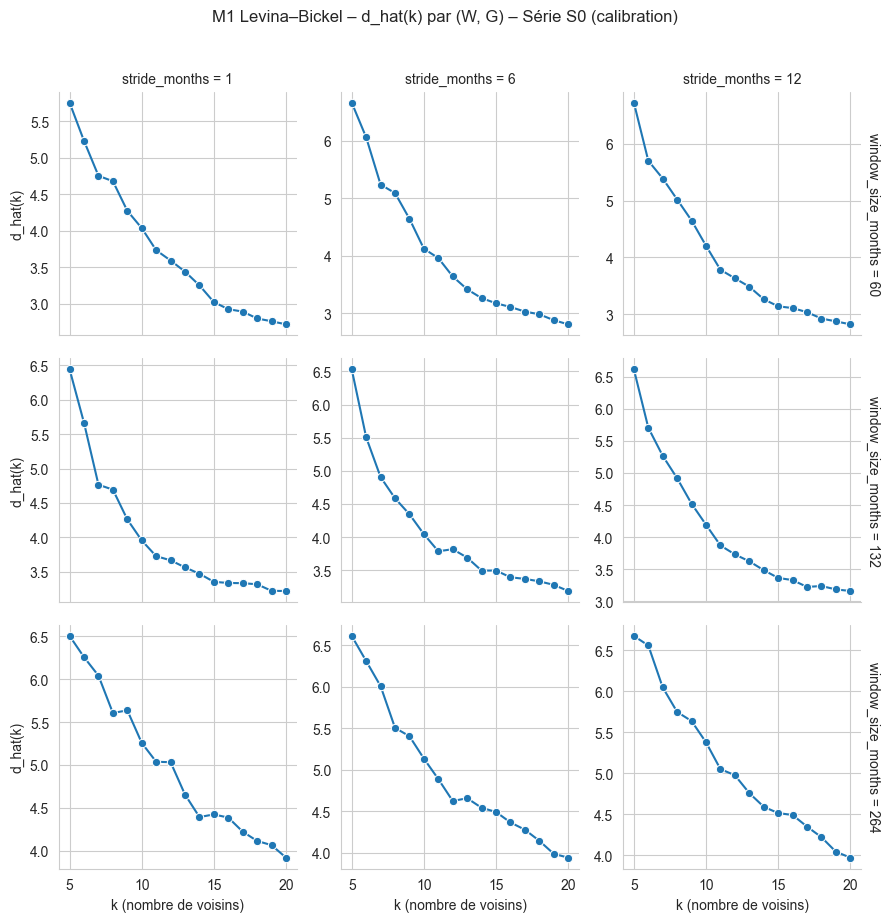

In [18]:
# Bloc 3.4 – Visualisation de d_hat(k) par (W, G) à partir de M1_S0_calibration_per_k.csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# 3.4.1 – Chargement des résultats M1 par k
DEST_DIR = PHASE2_ROOT / "data_phase2" / "d_estimates_calibration"
PER_K_PATH = DEST_DIR / "M1_S0_calibration_per_k.csv"

if not PER_K_PATH.exists():
    raise FileNotFoundError(
        f"M1_S0_calibration_per_k.csv introuvable à : {PER_K_PATH}.\n"
        "Assurez-vous que le Bloc 3.3 a bien été exécuté."
    )

df_per_k = pd.read_csv(PER_K_PATH)

print("Aperçu de M1_S0_calibration_per_k.csv :")
display(df_per_k.head())

# 3.4.2 – Tableau pivot d_hat(k) par (W, G)
pivot_table = df_per_k.pivot_table(
    index="k",
    columns=["window_size_months", "stride_months"],
    values="d_hat_k",
)
print("\nTableau pivot : d_hat(k) par taille de fenêtre W et pas G")
display(pivot_table)

# 3.4.3 – Figures : d_hat(k) en fonction de k, facetté par (W, G)
sns.set_style("whitegrid")

g = sns.FacetGrid(
    df_per_k,
    row="window_size_months",
    col="stride_months",
    margin_titles=True,
    sharey=False,
)
g.map_dataframe(
    sns.lineplot,
    x="k",
    y="d_hat_k",
    marker="o",
)
g.set_axis_labels("k (nombre de voisins)", "d_hat(k)")
g.fig.suptitle("M1 Levina–Bickel – d_hat(k) par (W, G) – Série S0 (calibration)", y=1.02)

plt.tight_layout()

# 3.4.4 – Sauvegarde de la figure dans artifacts
ARTIFACTS_DIR = PHASE2_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

FIG_PATH = ARTIFACTS_DIR / "M1_S0_dhatk_by_WG.png"
g.savefig(FIG_PATH, dpi=150, bbox_inches="tight")

print(f"\nFigure sauvegardée dans : {FIG_PATH}")

# 3.4.5 – Logging
log_message(
    "INFO",
    (
        "Visualisation de d_hat(k) par (W,G) générée à partir de M1_S0_calibration_per_k.csv "
        f"et sauvegardée dans {FIG_PATH.name}."
    ),
    block="BLOC_3.4",
)
log_metric(
    "M1_S0_visualization_generated",
    True,
    extra={
        "per_k_path": str(PER_K_PATH),
        "figure_path": str(FIG_PATH),
    },
)

### Bloc 3.5 – Choix d'une plage centrale de k pour M1 (Levina–Bickel) sur S0

Les résultats du Bloc 3.3–3.4 (tableau pivot et figure `M1_S0_dhatk_by_WG.png`) montrent que :

- d_hat(k) décroît fortement entre `k=5` et ~`k=10` (zone très instable) ;
- au‑delà, la pente reste décroissante mais plus douce, avec des valeurs qui se
  stabilisent vers :
  - ~3–3.5 pour W=60 et W=132,
  - ~4–4.5 pour W=264.

Pour **documenter clairement** nos choix méthodologiques, nous définissons :

- une **plage complète de diagnostic** : `k ∈ [5, 20]`  
  (déjà sauvegardée dans `M1_S0_calibration_per_k.csv`) ;
- une **plage centrale de travail** pour M1 sur S0 :

  \[
  k_{\text{core,min}} = 10, \quad k_{\text{core,max}} = 18
  \]

Cette plage est un **compromis explicite** :

- on évite les très petits k (5–8) où d_hat(k) est très élevé et très instable ;
- on reste sous `k = 20` pour ne pas basculer sur des voisinages trop globaux ;
- on garde une marge de variation suffisante pour quantifier l’**incertitude** de M1.

Nous allons maintenant :

1. filtrer `M1_S0_calibration_per_k.csv` sur `k ∈ [10, 18]` ;
2. calculer, pour chaque combinaison `(W, G)` :

   - `d_core_mean`, `d_core_std`, `d_core_min`, `d_core_max`
     (sur cette plage centrale de k) ;

3. sauvegarder ces résumés dans :

   - `data_phase2/d_estimates_calibration/M1_S0_calibration_summary_core_k.csv`

La plage complète `[5, 20]` restera disponible pour diagnostic et pour vérifier que
les conclusions ne dépendent pas d’un choix caché de k.